In [1]:
import os, math, random
import numpy as np
import pandas as pd
from os.path import join as opj
from sklearn import mixture
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from utils import *
random.seed(3694237224100457556)


In [2]:
CUR_DIR = os.getcwd()

WOVEN_DATA = pd.read_csv(opj(CUR_DIR, 'data', 'wovenab', 'wovenab.csv'))
WOVEN_DATA[['scene', 'gtmass', 'gtstiff']] = WOVEN_DATA['target'].str.split('_', expand=True)
WOVEN_DATA['stiff_diff'] = WOVEN_DATA['stiff']-WOVEN_DATA['gtstiff'].astype(float)
WOVEN_DATA['mass_diff'] = WOVEN_DATA['mass']- WOVEN_DATA['gtmass'].astype(float)
WOVEN_DATA['chain'] = WOVEN_DATA['fname'].apply(lambda x: x.split('.json')[0].split('_')[-1])
WOVEN_DATA['chain'] = WOVEN_DATA['chain'].astype(int)
WOVEN_DATA = WOVEN_DATA[WOVEN_DATA['chain'] <= 62].reset_index(drop=True)
WOVEN_DATA = WOVEN_DATA[WOVEN_DATA['scene'] == 'wind'].reset_index(drop=True)

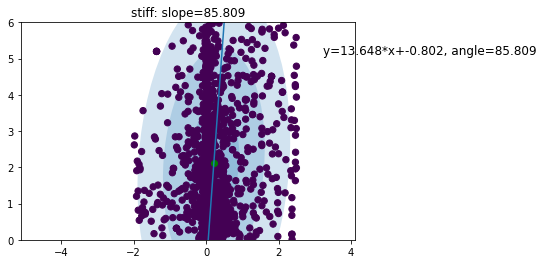

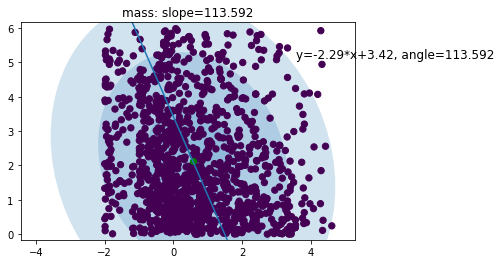

In [3]:
fig_idx = 0

X_stiff = np.column_stack((WOVEN_DATA.stiff_diff, WOVEN_DATA.ext_force))
gmm_stiff = mixture.GaussianMixture(n_components=1, covariance_type='full', random_state=42)
stiff_angle = round(fit_gmm(gmm_stiff, X_stiff), 3)
plot_gmm(gmm_stiff, X_stiff, fig_idx = fig_idx, titles='stiff: slope={}'.format(stiff_angle))

fig_idx += 1
         
X_mass = np.column_stack((WOVEN_DATA.mass_diff, WOVEN_DATA.ext_force))
gmm_mass = mixture.GaussianMixture(n_components=1, covariance_type='full', random_state=42)
mass_angle = round(fit_gmm(gmm_mass, X_mass), 3)
plot_gmm(gmm_mass, X_mass, fig_idx = fig_idx, titles='mass: slope={}'.format(mass_angle))


In [4]:
random.seed(9)
stiff_angles, mass_angles = [], []

for i in range(1000):
    bootstrapped_df = WOVEN_DATA.sample(n=int(len(WOVEN_DATA)), replace=True)
    bootstrapped_df.reset_index(drop=True, inplace=True)

    X_stiff = np.column_stack((bootstrapped_df.stiff_diff, bootstrapped_df.ext_force))
    gmm_stiff = mixture.GaussianMixture(n_components=1, covariance_type='full', random_state=42)
    stiff_angle = round(fit_gmm(gmm_stiff, X_stiff), 3)
    stiff_angles.append(stiff_angle)

    X_mass = np.column_stack((bootstrapped_df.mass_diff, bootstrapped_df.ext_force))
    gmm_mass = mixture.GaussianMixture(n_components=1, covariance_type='full', random_state=42)
    mass_angle = round(fit_gmm(gmm_mass, X_mass), 3)
    mass_angles.append(mass_angle)

p_value = calc_p((np.array(mass_angles)-90)-(90-np.array(stiff_angles)))
print(f"cor(inferred mass, infered wind) - cor(inferred stiffness, inferred wind), p-value = {p_value}")

cor(inferred mass, infered wind) - cor(inferred stiffness, inferred wind), p-value = 0.002


## Test the model prediction

In [5]:
def fit_regression_model(df, model):
    X = df[['reldiff', 'ireldiff']]
    X = sm.add_constant(X)
    y = df[f"{model}_acc"]

    regressor = sm.OLS(y, X)
    result = regressor.fit()
    coefficients = result.params
    return coefficients['reldiff']

In [6]:
models = ['human', 'woven', 'dnn', 'wovenab', 'wovenab2']
conds = ['mass', 'stiff']

In [7]:
mean_all_cond = {}
for cond in conds:
    mean = {}
    csv_f = pd.read_csv(f'data/parsed_questions_{cond}.csv')
    csv_f['reldiff'] = abs(csv_f['reldiff'])
    csv_include_wind = csv_f[csv_f['exclude_scene'] != 'wind'].reset_index()
    regress_include_wind = csv_include_wind.groupby(['reldiff', 'ireldiff']).agg({
                    'woven_acc': 'mean',
                    'human_acc': 'mean',
                    'dnn_acc': 'mean',
                    'wovenab_acc': 'mean',
                    'wovenab2_acc': 'mean',
                    'dnn2_acc': 'mean',
                }).reset_index()
    
    csv_exclude_wind = csv_f[csv_f['exclude_scene'] == 'wind'].reset_index()
    regress_exclude_wind = csv_exclude_wind.groupby(['reldiff', 'ireldiff']).agg({
                    'woven_acc': 'mean',
                    'human_acc': 'mean',
                    'dnn_acc': 'mean',
                    'wovenab_acc': 'mean',
                    'wovenab2_acc': 'mean',
                    'dnn2_acc': 'mean',
                }).reset_index()
    for model in models:
        beta_exclude = fit_regression_model(regress_exclude_wind, model)
        beta_include = fit_regression_model(regress_include_wind, model)
        diff = beta_exclude - beta_include
        mean[model] = diff
    mean_all_cond[cond] = mean

model=human, p=0.0
model=woven, p=0.0
model=dnn, p=0.0
model=wovenab, p=0.49
model=wovenab2, p=0.574


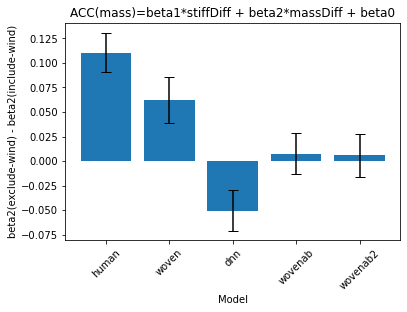

model=human, p=0.212
model=woven, p=0.0
model=dnn, p=0.016
model=wovenab, p=0.148
model=wovenab2, p=0.244


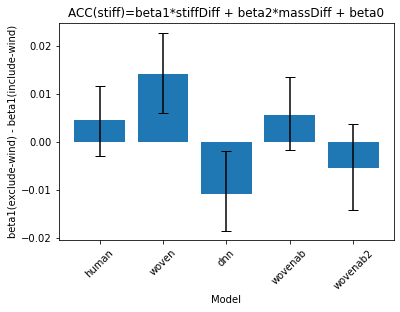

In [8]:
## bootstrap CI
regress_beta_ci_dir = 'data/mass_wind'
columns = ['model', 'mean', 'lower_ci', 'higher_ci']

for cond in conds:
    df = pd.DataFrame(columns=columns)
    cond_short = 'bs' if cond == 'stiff' else cond
    for model in models:
        cur_f = f'bimodality_data_model={model}_exp={cond}_boot=1000.csv'
        cur_f = opj(regress_beta_ci_dir, cur_f)
        cur_f = pd.read_csv(cur_f)
        cur_ci = ci_95(cur_f[f'{cond_short}_coeff_exclude'] - cur_f[f'{cond_short}_coeff_include'])
        p=calc_p(cur_f[f'{cond_short}_coeff_exclude'] - cur_f[f'{cond_short}_coeff_include'])
        print(f'model={model}, p={p}')
        row = {'model': model, 'mean': mean_all_cond[cond][model], 'lower_ci': cur_ci[0], 'higher_ci': cur_ci[1]}
        df = df.append(row, ignore_index=True)
        
    # PLot
    models = df['model']
    mean_values = df['mean']
    lower_ci_values = df['lower_ci']
    higher_ci_values = df['higher_ci']

    errors_lower = mean_values - lower_ci_values
    errors_upper = higher_ci_values - mean_values
    errors = [errors_lower, errors_upper]
    plt.bar(models, mean_values, yerr=errors, capsize=5)

    plt.xlabel('Model')
    ylabel = 'beta2(exclude-wind) - beta2(include-wind)' if cond == 'mass' else 'beta1(exclude-wind) - beta1(include-wind)'
    plt.ylabel(ylabel)
    plt.title(f'ACC({cond})=beta1*stiffDiff + beta2*massDiff + beta0')
    plt.xticks(rotation=45)
    plt.show()